# Getting Started:
## A simple driving model training and evaluation pipeline using the Drive360 dataset and PyTorch.

## Loading data from Drive360 dataset.

The **dataset.py** file contains the 3 classes necessary for creating a Drive360Loader. Using the **config.json** file to specify the location of the csv and data directory, we can generate phase (train, validation, test) specific data loaders that can output samples from each set. Adjust the **dataset.py** to your preferred training framework.

In [1]:
import torch
import json
import torch.optim as optim
import torch.nn as nn
import time
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from copy import deepcopy
import math

from dataset import Drive360Loader

# load the config.json file that specifies data 
# location parameters and other hyperparameters 
# required.
#config = json.load(open('./config_full_downsampled.json'))
config = json.load(open('./config_hybrid_full.json'))

# create a train, validation and test data loader
train_loader = Drive360Loader(config, 'train')
validation_loader = Drive360Loader(config, 'validation')
test_loader = Drive360Loader(config, 'test')

# print the data (keys) available for use. See full 
# description of each data type in the documents.
print('Loaded train loader with the following data available as a dict.')
print(train_loader.drive360.dataframe.keys())

total_batch = len(train_loader)
print("Ready to train on {}".format(torch.cuda.current_device()))

Phase: train # of data: 39897
Phase: validation # of data: 10626
Phase: test # of data: 27920
Loaded train loader with the following data available as a dict.
Index(['cameraRight', 'cameraFront', 'cameraRear', 'cameraLeft', 'here',
       'tomtom', 'gpsLatitude', 'gpsLongitude', 'gpsAltitude', 'gpsPrecision',
       'hereMmLatitude', 'hereMmLongitude', 'hereSpeedLimit',
       'hereSpeedLimit_2', 'hereFreeFlowSpeed', 'hereSignal', 'hereYield',
       'herePedestrian', 'hereIntersection', 'hereMmIntersection',
       'hereSegmentExitHeading', 'hereSegmentEntryHeading',
       'hereSegmentOthersHeading', 'hereCurvature', 'hereCurrentHeading',
       'here1mHeading', 'here5mHeading', 'here10mHeading', 'here20mHeading',
       'here50mHeading', 'hereTurnNumber', 'canSteering', 'canSpeed',
       'chapter'],
      dtype='object')
Ready to train on 0


In [2]:
# Print iterations progress
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = printEnd)
    # Print New Line on Complete

## Training a basic driving model

Create your driving model. This is specific to your learning framework. 

Below we give a very basic dummy model that uses the front facing camera and a resnet34 + LSTM architecture to predict canSteering and canSpeed. 

In [3]:
from models import HereModel

First, define some helper functions. 

In [4]:
def save_model(model, optimizer, epoch, loss, path):
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss
                }, path)
    
def resume_model(model, optimizer, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    model.cuda()
    #optimizer.cuda()
    
    return epoch, loss

def load_model(model, path):
    model.load_state_dict(torch.load(path))
    model.eval()

A basic training procedure that iterates over the train_loader and feeds each sample into our dummy model, subsequently calculates loss. We kill after 20 batches just

In [5]:
def train_model(model, optimizer, criterion_speed, criterion_steering, epochs, name="model", resume_path=None):
    hist_train_loss_speed = []
    hist_train_loss_steering = []
    hist_valid_loss_speed = []
    hist_valid_loss_steering = []
    
    model.cuda()
    best_model = None
    best_valid = math.inf
    
    if resume_path:
        epoch, _ = resume_model(model, optimizer, resume_path)
    else:
        epoch = 0
    
    while epoch < epochs:
        start = time.time()
        printProgressBar(0, total_batch, prefix = 'Progress:', suffix = 'Complete', length = 50)
        model.train()
        progress_counter = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            prediction = model(data)

            steering_loss = criterion_steering(prediction['canSteering'].cuda(), target['canSteering'].cuda())
            speed_loss = criterion_speed(prediction['canSpeed'].cuda(), target['canSpeed'].cuda())
            loss = steering_loss + speed_loss
            hist_train_loss_speed.append(speed_loss.cpu().detach().numpy())
            hist_train_loss_steering.append(steering_loss.cpu().detach().numpy())
            
            loss.backward()
            optimizer.step()
                
            progress_counter += 1
            if progress_counter >= 10:
                printProgressBar(batch_idx + 1, total_batch, prefix = 'Progress:', suffix = 'Complete', length = 50)
                progress_counter = 0

        printProgressBar(total_batch, total_batch, prefix = 'Progress:', suffix = 'Complete', length = 50)
        print()
        
        end = time.time() 
        print("Training minutes elapsed epoch{}: {}, {} left".format(epoch, round((end - start) / 60, 2), round((end - start) * (epochs - epoch - 1) / 60, 2)))

        model.eval()

        speed_sum = 0
        steering_sum = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(validation_loader):
                optimizer.zero_grad()
                prediction = model(data)
                speed_dif = prediction['canSpeed'].cpu() - target['canSpeed']
                steering_dif = prediction['canSteering'].cpu() - target['canSteering']
                speed_sum += (np.square(speed_dif)).mean()
                steering_sum += (np.square(steering_dif)).mean()
        hist_valid_loss_speed.append(speed_sum)
        hist_valid_loss_steering.append(steering_sum)
        print("Steering Error: {}\nSpeed Error: {}".format(float(steering_sum), float(speed_sum)))
        
        # Early Stopping
        if steering_sum < best_valid:
            best_model = deepcopy(model)
            best_valid = steering_sum
            print("Find a new best model!")
        
        epoch += 1
    
    plt.plot(hist_train_loss_speed)
    plt.title("Speed Loss")
    now = datetime.now()
    plt.plot(hist_train_loss_speed)
    plt.title("Speed Loss")
    plt.savefig("./saved_figures/{}-{}-{}-speed.png".format(epochs, name, now.strftime("%m-%d-%Y-%H-%M-%S")))
    plt.show()
    plt.plot(hist_train_loss_steering)
    plt.title("Steering Loss")
    plt.savefig("./saved_figures/{}-{}-{}-angle.png".format(epochs, name, now.strftime("%m-%d-%Y-%H-%M-%S")))
    plt.show()
    save_model(model, optimizer, epoch, loss, 
               "./saved_models/{}-{}-{}.pt".format(epochs, name, now.strftime("%m-%d-%Y-%H-%M-%S")))
    print("Saving current_model to " + "./saved_models/{}-{}-{}.pt".format(epochs, name, now.strftime("%m-%d-%Y-%H-%M-%S")))
    save_model(best_model, optimizer, epoch, loss, 
               "./best_models/.pt".format(name))
    plt.plot(hist_valid_loss_speed)
    plt.title("Validating Speed Loss")
    plt.show()
    plt.plot(hist_valid_loss_steering)
    plt.title("Validating Steering Loss")
    plt.show()

We use pandas to create a submission file which is simply a 2-column csv with a canSteering and canSpeed prediction for each row in the **drive360_test.csv** a total of 305437 rows/predictions not including the header. See the **sample_submission.csv** file as an example.

IMPORTANT: for the test phase indices will start 10s (100 samples) into each chapter this is to allow challenge participants to experiment with different temporal settings of data input. If challenge participants have a greater temporal length than 10s for each training sample, then they must write a custom function here. Please check out the **dataset.py** file for additional explanation.

In [6]:
normalize_targets = config['target']['normalize']
target_mean = config['target']['mean']
target_std = config['target']['std']

def add_results(results, output):
    steering = np.squeeze(output['canSteering'].cpu().data.numpy())
    speed = np.squeeze(output['canSpeed'].cpu().data.numpy())
    if normalize_targets:
        steering = (steering*target_std['canSteering'])+target_mean['canSteering']
        speed = (speed*target_std['canSpeed'])+target_mean['canSpeed']
    if np.isscalar(steering):
        steering = [steering]
    if np.isscalar(speed):
        speed = [speed]
    results['canSteering'].extend(steering)
    results['canSpeed'].extend(speed)

test_chapter_length = [2997 for i in range(98)]
test_chapter_length[14] = 2996
test_chapter_length[36] = 2996
test_chapter_length[38] = 2996
test_chapter_length[63] = 1277
test_chapter_length[64] = 2861
test_chapter_length[66] = 2014
test_chapter_length[70] = 2996
test_chapter_length[72] = 2690
test_chapter_length[81] = 2106
test_chapter_length[85] = 2996
test_chapter_length[92] = 2996

for i in range(len(test_chapter_length)):
    test_chapter_length[i] -= 100
    
print("Number of test data: {}".format(sum(test_chapter_length)))

import pandas as pd

def create_submission(model, initial_offset, interval):
    now = datetime.now()
    file_name = "./submissions/{}-{}.csv".format("model", now.strftime("%m-%d-%Y-%H-%M-%S"))
    results = {'canSteering': [],
               'canSpeed': []}

    final_result = {'canSteering': np.zeros(279863, dtype="float64"),
                    'canSpeed': np.zeros(279863, dtype="float64")}
    final_result['canSteering'][:] = np.nan
    final_result['canSpeed'][:] = np.nan


    start = time.time()
    print("Start creating submission file {}, offset:{}, interval:{}".format(file_name, initial_offset, interval))
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            prediction = model(data)
            add_results(results, prediction)
    
    index = 0
    chapter_cap = 0
    r_index = 0
    for chapter_num in test_chapter_length:
        index = chapter_cap + initial_offset
        
        #Fill the leading indices
        final_result['canSteering'][chapter_cap] = results['canSteering'][r_index]
        final_result['canSpeed'][chapter_cap] = results['canSpeed'][r_index]
        
        chapter_cap += chapter_num
        while index < chapter_cap:
            final_result['canSteering'][index] = results['canSteering'][r_index]
            final_result['canSpeed'][index] = results['canSpeed'][r_index]
            
            index += interval
            r_index += 1
            
        #Fill the trailing indices
        #print(index, chapter_cap, r_index)
        final_result['canSteering'][chapter_cap - 1] = results['canSteering'][r_index - 1]
        final_result['canSpeed'][chapter_cap - 1] = results['canSpeed'][r_index - 1]

    df = pd.DataFrame.from_dict(final_result, dtype='float64')
    df.interpolate(method='linear', limit_direction='forward', inplace=True)
    df.to_csv(file_name, index=False)

    end = time.time() 
    print("Minutes elapsed: {}".format(round((end - start) / 60, 2)))

Number of test data: 279863


## Local evaluation of the model and creating a submission file.

Progress: |██████████████████████████████████████████████████| 100.0% Complete
Training minutes elapsed epoch0: 32.23, 612.28 left
Steering Error: 29.4238338470459
Speed Error: 25.48678207397461
Find a new best model!
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Training minutes elapsed epoch1: 31.89, 574.0 left
Steering Error: 28.515642166137695
Speed Error: 21.263927459716797
Find a new best model!
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Training minutes elapsed epoch2: 31.79, 540.41 left
Steering Error: 24.529821395874023
Speed Error: 18.549964904785156
Find a new best model!
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Training minutes elapsed epoch3: 31.35, 501.58 left
Steering Error: 23.486059188842773
Speed Error: 19.375146865844727
Find a new best model!
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Training minutes elapsed epoch4: 27.06, 4

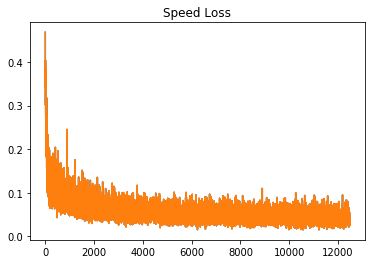

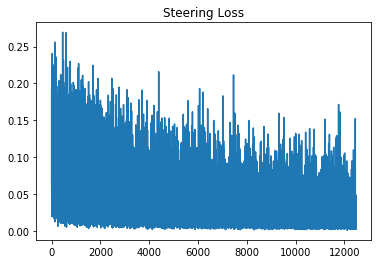

Saving current_model to ./saved_models/20-model-11-29-2019-02-12-20.pt


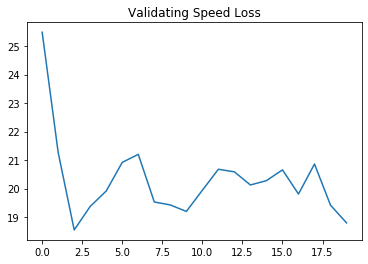

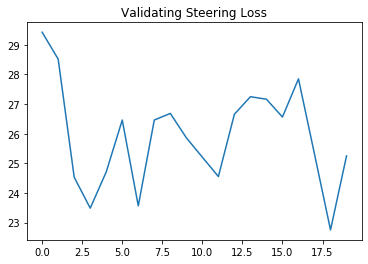

NameError: name 'index' is not defined

In [7]:
model = HereModel()
train_model(model, optim.AdamW(model.parameters(), lr=0.0001), nn.SmoothL1Loss(), nn.SmoothL1Loss(), 20)
create_submission(model, config["initial_offset"], config["interval"])